In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tickers = ['NVDA', 'AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NFLX', 'V', 'MA']
price_hists = []
for ticker in tickers:
    price_hists.append(yf.Ticker(ticker).history(interval='1h', start='2022-03-01', end='2024-02-01')['Close'].to_numpy())

In [3]:
def gen_price_series(size=10000, k=3, a=0.9, instances=1):
    p_series = np.ndarray((instances, size,), dtype=np.float32)
    b_series = np.ndarray((instances, size,), dtype=np.float32)
    p_series[:, 0] = 0
    b_series[:, 0] = 0

    for i in range(1, size):
        p_series[:, i] =  p_series[:, i-1] + b_series[:, i-1] + k * np.random.normal(size=instances)
        b_series[:, i] = a * b_series[:, i-1] + np.random.normal(size=instances)

    # shape: (instances)
    R = np.max(p_series, axis=1) - np.min(p_series, axis=1)
    z_series = np.exp(p_series / np.repeat(R[:, np.newaxis], size, axis=1))

    return z_series, p_series

'''To convert real prices into model-appropriate price series:
    1. Set the initial price as 0.
    2. Scale the price to [-1, 1], with 0 as the mean.
    3. Apply exp.'''

# this function takes MULTIPLE INPUTS!!!
def normalize_price_series(price_series):
    initial_prices = price_series[:, 0]
    range = np.max(price_series, axis=1) - np.min(price_series, axis=1)
    scaled_prices = (price_series - np.repeat(initial_prices[:, np.newaxis], price_series.shape[1], axis=1)) / np.repeat(range[:, np.newaxis], price_series.shape[1], axis=1)
    
    return np.exp(scaled_prices)

zt_list = [normalize_price_series(hist[np.newaxis, :]) for hist in price_hists]

In [4]:
# Following 2 functions take whole arrays, of shape (instances, size)

def calc_price_returns(zt):
    # returns the set rt, with the first element (0) being NaN
    rt = np.ndarray(zt.shape, dtype=np.float32)
    rt[:, 0] = np.nan
    rt[:, 1:] = zt[:, 1:] - zt[:, :-1]
    return rt
    


# Following 2 functions take slices of the arrays, of shape (instances,)

def calc_return(mu, rt, Ft_curr, Ft_prev, rft=tf.constant(0.0), delta=tf.constant(0.0)):
    '''Calculates the returns (Rt) on-line.'''

    return mu * (rft + Ft_prev * (rt - rft) - delta * tf.math.abs(Ft_curr - Ft_prev))

def calc_DSR(n, Rt, At_prev, Bt_prev):
    '''Calculates the differential Sharpe ratios (DSR, Dt) on-line.'''

    At_curr = At_prev + n * (Rt - At_prev)
    Bt_curr = Bt_prev + n * (tf.math.square(Rt) - Bt_prev)

    dDt_dRt = (Bt_prev - At_prev * Rt) / tf.math.pow((Bt_prev - tf.math.square(At_prev)), 1.5)

    return dDt_dRt, At_curr, Bt_curr


from math import prod
# Repeat grades of shape (instances,) to shape (instances,) + grad.shape
def reshape_grad(grad, shape):
    # takes a tf.Tensor grad of shape (instances,) and the target shape (variables)
    instances = grad.shape[0]
    total_elements = prod(shape)
    grad = tf.repeat(grad, int(total_elements / instances))
    grad = tf.reshape(grad, shape)
    
    return grad

@tf.function
def calc_grads(zt, rt, At, Bt, N, MU, F_model, F_prev, rft=tf.constant(0.0), transaction_cost=tf.constant(0.0), random=tf.constant(1.0)):
    '''
    zt: zt[:, t - INPUT_SIZE + 1:t + 1]
    rt: rt[:, t]
    At: At[:, t-1]
    Bt: Bt[:, t-1]
    '''

    # print("TRACING calc_grads()")

    INSTANCES = zt.shape[0]

    with tf.GradientTape(persistent=True) as tape:
        F_curr = tf.reshape(F_model(zt), (INSTANCES,))
        Rt = calc_return(MU, rt, F_curr, F_prev, rft, transaction_cost)

        dDt_dRt, At_new, Bt_new = calc_DSR(N, Rt, At, Bt)

    # calculate derivatives.
    dRt_dFcurr = tape.gradient(Rt, F_curr) # shape: (instances,)
    dRt_dFprev = tape.gradient(Rt, F_prev) # shape: (instances,)
    dF_dTheta = tape.jacobian(F_curr, F_model.trainable_variables) # shape: (instances, MODEL VAR SHAPE)

    

    return Rt, F_curr, At_new, Bt_new, dDt_dRt, dRt_dFcurr, dRt_dFprev, dF_dTheta

In [5]:
def test_performance(zt, Ft):
    # zt: (instances, size)
    # Ft: (instances, size)

    instances = zt.shape[0]
    size = zt.shape[1]
    Ft = np.sign(Ft)

    values = np.ones((instances, size))
    owned = np.zeros((instances,))
    money = np.ones((instances,))
    values[:, 0] = money

    values_ideal = np.ones((instances, size))
    owned_ideal = np.zeros((instances,))
    money_ideal = np.ones((instances,))
    values_ideal[:, 0] = money_ideal

    for t in range(INPUT_SIZE, size - 1):

        # Model Ft

        # buy if Ft 1, owned 0 --> owned 1
        # sell if Ft -1, owned 1 --> owned 0

        # hold if Ft 0, owned 0 or 1
        # hold if Ft 1, owned 1
        # hold if Ft -1, owned 0

        # model
        buy = np.clip(Ft[:, t] * (1 - owned), 0, 1) # 1 if BUY, 0 if not
        sell = np.clip(-Ft[:, t] * owned, 0, 1) # 1 if SELL, 0 if not
        decision = buy - sell # 1 if BUY, -1 if SELL, 0 if HOLD
        owned = np.clip(owned + decision, 0, 1)
        money -= decision * zt[:, t]
        values[:, t] = money + owned * zt[:, t]

        # ideal
        deltas_ideal = np.sign(zt[:, t + 1] - zt[:, t])
        buy_ideal = np.clip(deltas_ideal * (1 - owned_ideal), 0, 1)
        sell_ideal = np.clip(-deltas_ideal * owned_ideal, 0, 1)
        decision_ideal = buy_ideal - sell_ideal
        owned_ideal = np.clip(owned_ideal + decision_ideal, 0, 1)
        money_ideal -= decision_ideal * zt[:, t]
        values_ideal[:, t] = money_ideal + owned_ideal * zt[:, t]
    
    values[:, -1] = np.nan
    values_ideal[:, -1] = np.nan

    return (values[-1] / zt[-1], values_ideal[-1] / zt[-1]), (values, values_ideal)

In [6]:
# INPUT_SIZE = 30
# LEARNING_RATE = 0.0001
# F_model = keras.models.load_model("good_model.h5")
# F_model.summary()



from keras import layers

INPUT_SIZE = 30
TANH_CONSTANT = 0.01

input = layers.Input(shape=(INPUT_SIZE, 1))
# x = layers.Dense(30, activation='elu')(input)
x = layers.GRU(20, activation="elu", return_sequences=False)(input)
x = layers.Dense(20, activation='elu')(x)
x = layers.Dense(1, activation='linear')(x)
x = layers.Add()([tf.math.tanh(x), x * tf.constant(TANH_CONSTANT, dtype=tf.float32)]) # This bit is the activation function: tanh(x) + x * TANH_CONSTANT
F_model = keras.Model(inputs=input, outputs=x)
F_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 1)]      0           []                               
                                                                                                  
 gru (GRU)                      (None, 20)           1380        ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 20)           420         ['gru[0][0]']                    
                                                                                                  
 dense_1 (Dense)                (None, 1)            21          ['dense[0][0]']                  
                                                                                              

Series length: 3369
Mean gradient:  -6.3248485974353385e-06
Mean clipped gradient:  -6.3248485974353385e-06
# of trades:  4.0
mean SR:  -0.007138983311662057
mean DSR:  -0.19678385777521115


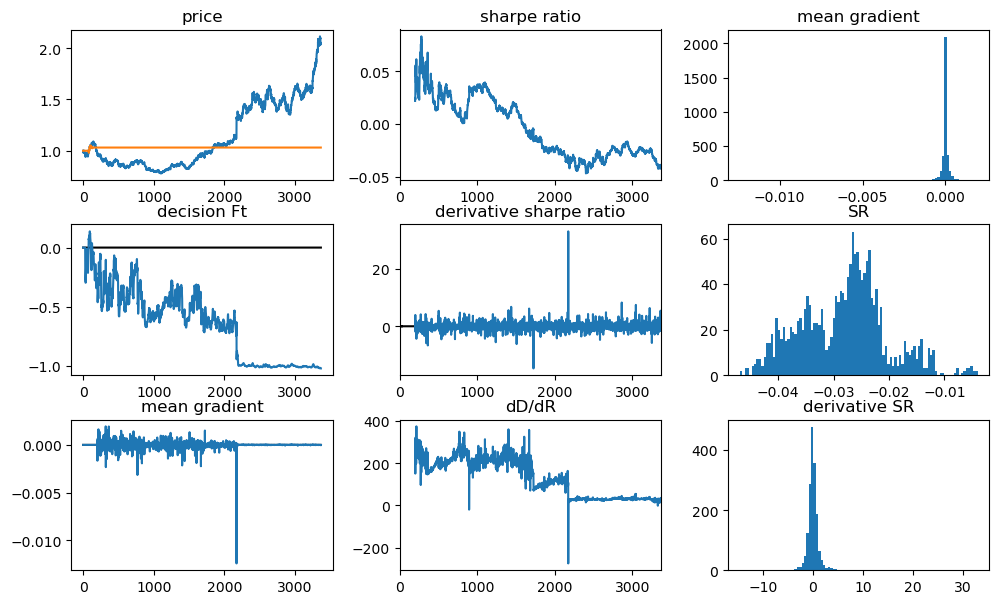

Series length: 3369
Mean gradient:  -3.156048544719911e-06
Mean clipped gradient:  -3.156048544719911e-06
# of trades:  10.0
mean SR:  0.00403614464151761
mean DSR:  -0.014871979875956612


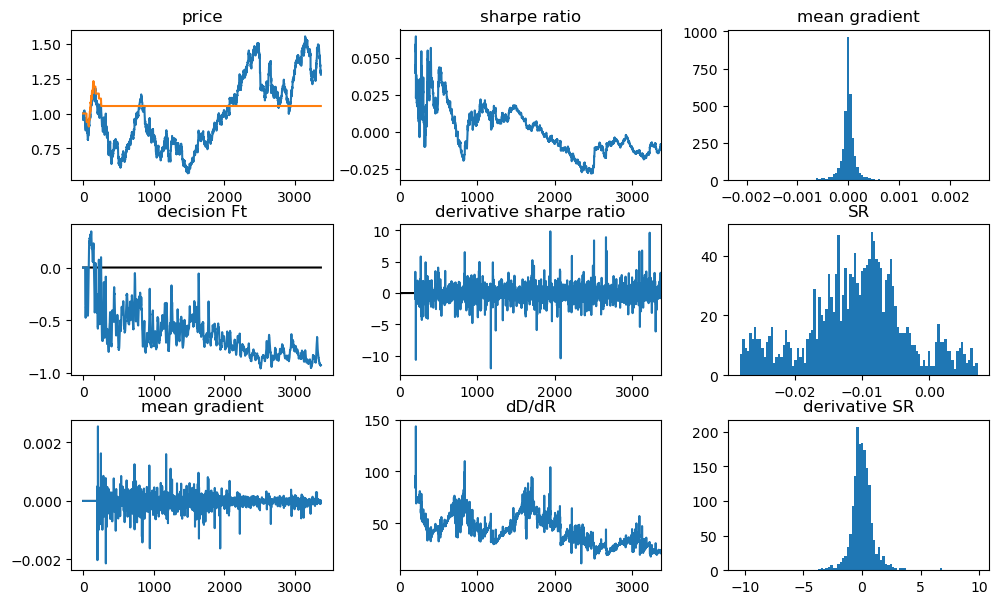

Series length: 3369
Mean gradient:  -5.219139234747813e-06
Mean clipped gradient:  -5.219139234747813e-06
# of trades:  12.0
mean SR:  3.503188926822409e-05
mean DSR:  -0.014102983050787101


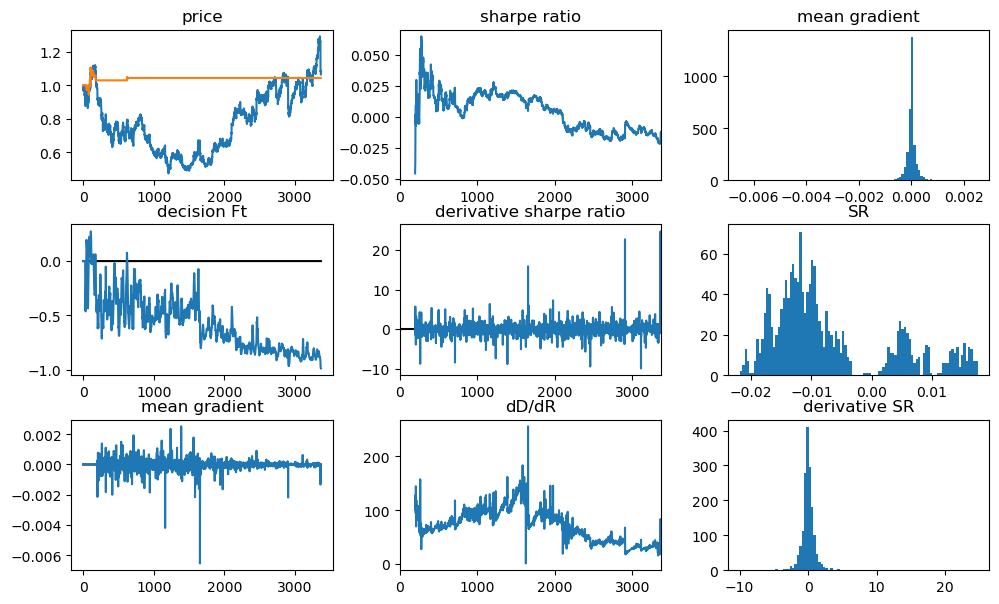

Series length: 3369
Mean gradient:  -3.2806900254954845e-06
Mean clipped gradient:  -3.2806900254954845e-06
# of trades:  10.0
mean SR:  -0.006281387014296014
mean DSR:  0.0007620454777660891


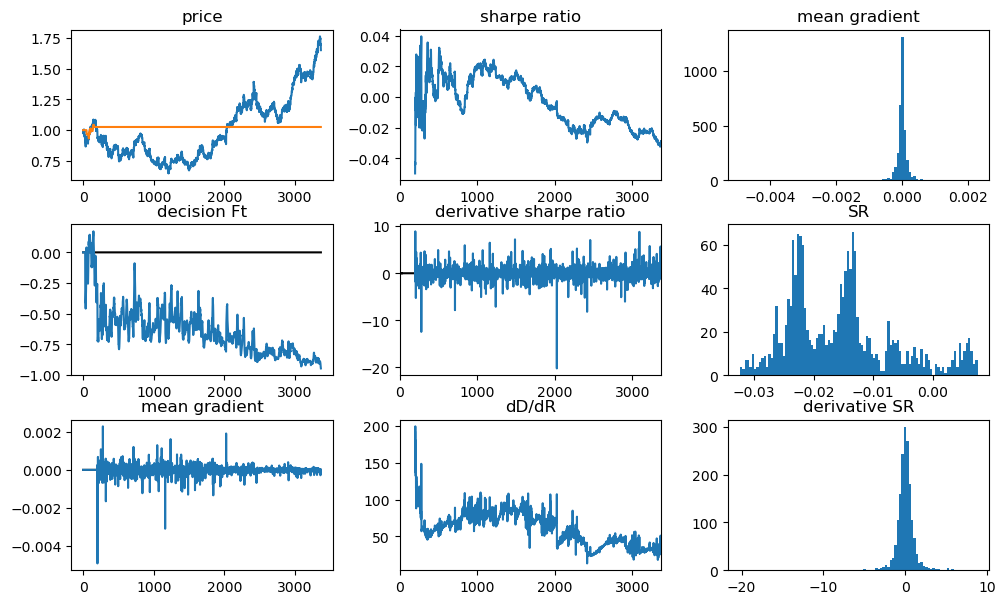

Series length: 3369


KeyboardInterrupt: 

In [7]:
import warnings, sys
warnings.filterwarnings("ignore")

# HYPERPARAMETERS
LEARNING_RATE = 0.001
MAX_GRAD = 100 * LEARNING_RATE
MU = tf.constant(3.0)
N = tf.constant(0.01)
# RISKFREE_RETURN = tf.constant(1.59e-4)
RISKFREE_RETURN = tf.constant(0.0)
# TRANS_COST = tf.constant(0.01)
TRANS_COST = tf.constant(0.0)
TRADING_DELAY = 200
K = 3
A = 0.9

INSTANCES = 1

for zt in zt_list:
    # F_model = keras.models.load_model("strategy1_trained.h5")
    F_model = keras.models.load_model("model.h5")
    # DEFINE A BUNCH OF STUFF
    SERIES_LENGTH = zt.shape[1]
    print("Series length:", SERIES_LENGTH)
    rt = calc_price_returns(zt)
    Ft = np.zeros((INSTANCES, SERIES_LENGTH,), dtype=np.float32)

    # breaks if init at one; MUST INIT ZERO
    At = np.zeros((INSTANCES, SERIES_LENGTH,), dtype=np.float32)
    Bt = np.zeros((INSTANCES, SERIES_LENGTH,), dtype=np.float32)
    dF_dTheta_prev = None

    Rt_series = np.zeros((INSTANCES, SERIES_LENGTH,))
    SR_series = np.zeros((INSTANCES, SERIES_LENGTH,))
    DSR_series = np.zeros((INSTANCES, SERIES_LENGTH,))
    dD_series = np.ones((INSTANCES, SERIES_LENGTH,))
    autodiff_series = np.ones((INSTANCES, SERIES_LENGTH,))
    bench_series = np.zeros((INSTANCES, SERIES_LENGTH,))
    grad_series = np.zeros((SERIES_LENGTH,))
    gradC_series = np.zeros((SERIES_LENGTH,))
    trade_count = np.zeros((INSTANCES,))


    for t in range(INPUT_SIZE, SERIES_LENGTH):
        Rt, Ft[:, t], At[:, t], Bt[:, t], dDt_dRt, dRt_dFcurr, dRt_dFprev, dF_dTheta = calc_grads(zt[:, t - INPUT_SIZE + 1:t + 1], rt[:, t], At[:, t-1], Bt[:, t-1], N, MU, F_model, tf.Variable(Ft[:, t-1]), RISKFREE_RETURN, TRANS_COST)
        
        pos_changes = np.where(Ft[:, t] * Ft[:, t-1] < 0, 1, 0)
        trade_count += pos_changes

        Rt_series[:, t] = Rt
        SR_series[:, t] = np.mean(Rt_series[:, INPUT_SIZE:t], axis=1) / np.std(Rt_series[:, INPUT_SIZE:t], axis=1)
        DSR_series[:, t] = (Bt[:, t-1] * (Rt - At[:, t-1]) - (1/2) * (At[:, t-1] * (Rt ** 2 - Bt[:, t-1]))) / ((Bt[:, t-1] - At[:, t-1] ** 2) ** 1.5)
        dD_series[:, t] = dDt_dRt

        if t >= TRADING_DELAY:
            # multiply derivatives together.
            gradient_update = []
            grad_mean = np.ndarray((len(dF_dTheta),), dtype=np.float32)

            for i in range(len(dF_dTheta)):
                total_elements = prod(dF_dTheta[i].shape)

                # expand the "scalar" derivatives to the shape of the model variables. (jacobians)
                dDt_dRt_exp = reshape_grad(dDt_dRt, dF_dTheta[i].shape)
                dRt_dFcurr_exp = reshape_grad(dRt_dFcurr, dF_dTheta[i].shape)
                dRt_dFprev_exp = reshape_grad(dRt_dFprev, dF_dTheta[i].shape)

                grad = dDt_dRt_exp * (dRt_dFcurr_exp * dF_dTheta[i] + dRt_dFprev_exp * dF_dTheta_prev[i])
                grad = tf.reduce_sum(grad, axis=0)
                grad *= LEARNING_RATE / INSTANCES # divide by instances since the gradients are summed over all instances.

                gradient_update.append(grad)
                grad_mean[i] = tf.reduce_mean(grad)
                
            grad_series[t] = np.mean(grad_mean)

            # actually add the grads
            vars = F_model.trainable_variables
            grad_mean = np.ndarray((len(dF_dTheta),), dtype=np.float32)
            for i in range(len(vars)):
                grad = np.clip(gradient_update[i], -MAX_GRAD, MAX_GRAD)
                grad_mean[i] = tf.reduce_mean(grad)
                vars[i].assign_add(grad)
            gradC_series[t] = np.mean(grad_mean)
            '''--------------------------------------------'''

        if t >= TRADING_DELAY - 1:
            # need to continously update so that the first training step has a t-1 value.
            dF_dTheta_prev = dF_dTheta

    '''PLOT DIAGNOSTICS. -----------------'''
    deltas, val_series = test_performance(zt, Ft)

    for i in range(INSTANCES):
        print("Mean gradient: ", np.mean(grad_series))
        print("Mean clipped gradient: ", np.mean(grad_series))
        # test performance
        deltas, val_series = test_performance(zt, Ft)

        for i in range(1):
            print("# of trades: ", trade_count[i])
            print("mean SR: ", np.mean(SR_series[i, INPUT_SIZE + 2:]))
            print("mean DSR: ", np.mean(DSR_series[i, INPUT_SIZE + 2:]))

            fig, ax = plt.subplots(3, 3, figsize=(10, 6))
            fig.tight_layout()

            ax[0, 0].plot(zt[i])
            ax[0, 0].plot(val_series[0][i])
            ax[0, 0].set_title("price")

            ax[1, 0].plot(Ft[i] * 0, color='k')
            ax[1, 0].plot(Ft[i])
            # ax[1, 0].set_ylim([-1, 1])
            ax[1, 0].set_title("decision Ft")

            # ax[2, 0].plot(bench_series[i] * 0, color='k')
            # ax[2, 0].plot(bench_series[i])
            # ax[2, 0].set_ylim([-1, 1])
            # ax[2, 0].set_title("benchmark Ft")
            ax[2, 0].plot(grad_series * 0, color='k')
            ax[2, 0].plot(grad_series)
            # ax[2, 0].set_ylim([-1, 1])
            ax[2, 0].set_title("mean gradient")

        
            SR_cut = SR_series.copy()
            SR_cut[:, :TRADING_DELAY] = np.nan
            ax[0, 1].plot(SR_cut[i])
            ax[0, 1].set_xlim([0, SERIES_LENGTH])
            ax[0, 1].set_title("sharpe ratio")

            DSR_cut = DSR_series.copy()
            DSR_cut[:, :TRADING_DELAY] = np.nan
            ax[1, 1].plot(DSR_series[i] * 0, color='k')
            ax[1, 1].plot(DSR_cut[i])
            ax[1, 1].set_xlim([0, SERIES_LENGTH])
            ax[1, 1].set_title("derivative sharpe ratio")

            dD_cut = dD_series.copy()
            dD_cut[:, :TRADING_DELAY] = np.nan
            ax[2, 1].plot(dD_cut[i])
            ax[2, 1].set_xlim([0, SERIES_LENGTH])
            ax[2, 1].set_title("dD/dR")

            ax[0, 2].hist(grad_series, bins=100)
            ax[0, 2].set_title("mean gradient")
            ax[1, 2].hist(SR_cut[i, int(SERIES_LENGTH / 2):], bins=100)
            ax[1, 2].set_title("SR")
            ax[2, 2].hist(DSR_cut[i, int(SERIES_LENGTH / 2):], bins=100)
            ax[2, 2].set_title("derivative SR")


            plt.show()

            print("==========================================================================")

    '''-----------------------------------'''



In [ ]:
def gen_price_series(size=10000, k=3, a=0.9, instances=1):
    p_series = np.ndarray((instances, size,), dtype=np.float32)
    b_series = np.ndarray((instances, size,), dtype=np.float32)
    p_series[:, 0] = 0
    b_series[:, 0] = 0

    np.random.seed(np.random.randint(0, 1000))
    for i in range(1, size):
        p_series[:, i] =  p_series[:, i-1] + b_series[:, i-1] + k * np.random.normal(size=instances)
        b_series[:, i] = a * b_series[:, i-1] + np.random.normal(size=instances)

    # shape: (instances)
    R = np.max(p_series, axis=1) - np.min(p_series, axis=1)
    z_series = np.exp(p_series / np.repeat(R[:, np.newaxis], size, axis=1))

    return z_series, p_series

K = 2
A = 0.9

zt, pt = gen_price_series(size=10000, k=K, a=0.5, instances=1)
plt.plot(zt[0])
zt, pt = gen_price_series(size=10000, k=K, a=0.9, instances=1)
plt.plot(zt[0])
zt, pt = gen_price_series(size=10000, k=K, a=0.95, instances=1)
plt.plot(zt[0])
plt.show()

# zt, pt = gen_price_series(size=10000, k=2, a=A, instances=1)
# plt.plot(zt[0])
# zt, pt = gen_price_series(size=10000, k=3, a=A, instances=1)
# plt.plot(zt[0])
# zt, pt = gen_price_series(size=10000, k=4, a=A, instances=1)
# plt.plot(zt[0])
# plt.show()

plt.plot(zt_list[1][0])
plt.show()